# **Data Analysis and Preprocessing**

In [24]:
import pandas as pd

# Load the dataset
df = pd.read_csv('diabetes.csv')

# Display basic information
print("Dataset shape:", df.shape)
print("\nFirst 5 rows:")
print(df.head())

# Check for missing values
print("\nMissing values per column:")
print(df.isnull().sum())

# Basic statistics
print("\nDescriptive statistics:")
print(df.describe())

Dataset shape: (768, 9)

First 5 rows:
   Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin   BMI  \
0            6      148             72             35        0  33.6   
1            1       85             66             29        0  26.6   
2            8      183             64              0        0  23.3   
3            1       89             66             23       94  28.1   
4            0      137             40             35      168  43.1   

   DiabetesPedigreeFunction  Age  Outcome  
0                     0.627   50        1  
1                     0.351   31        0  
2                     0.672   32        1  
3                     0.167   21        0  
4                     2.288   33        1  

Missing values per column:
Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                       

**Data visualization**

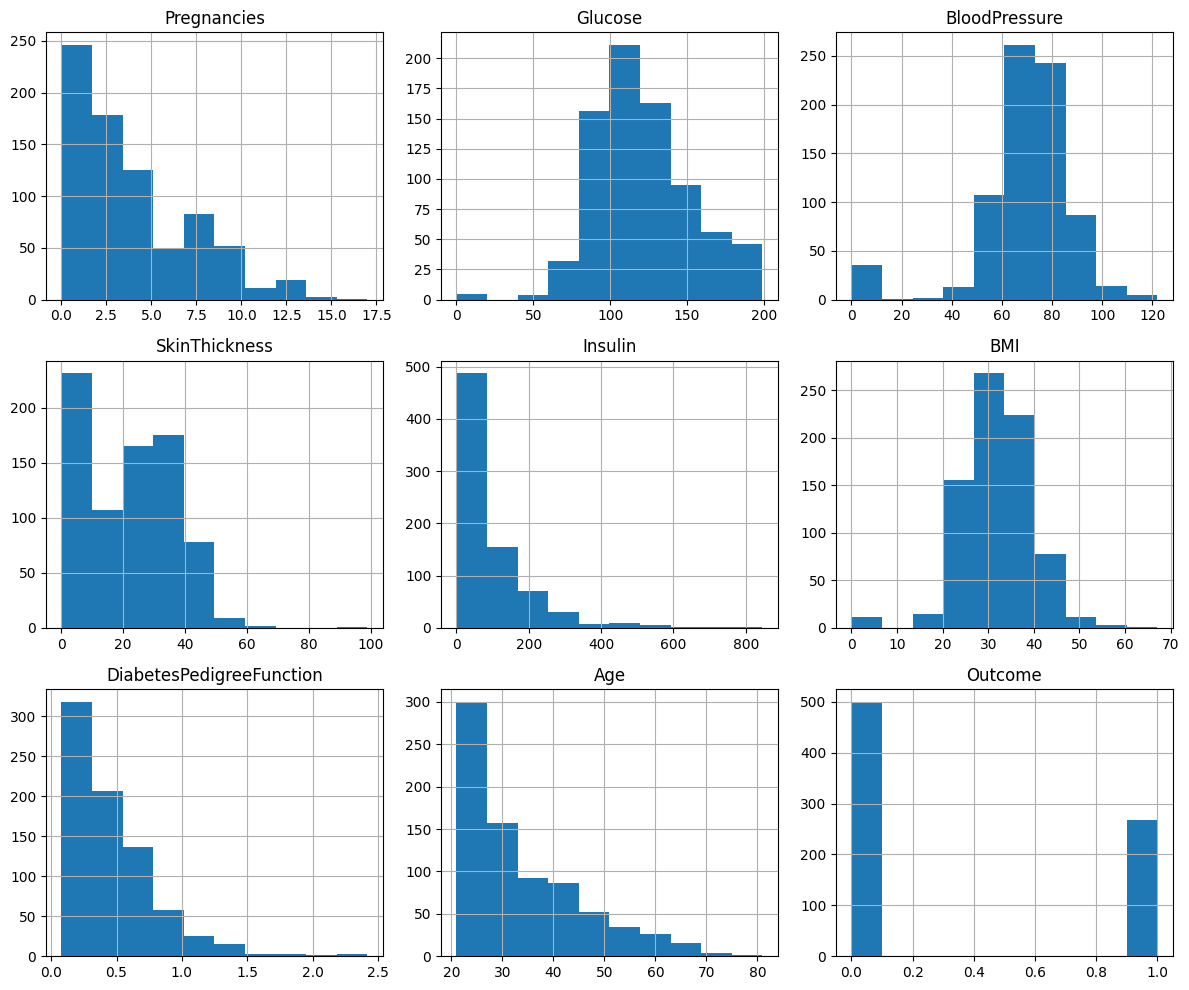

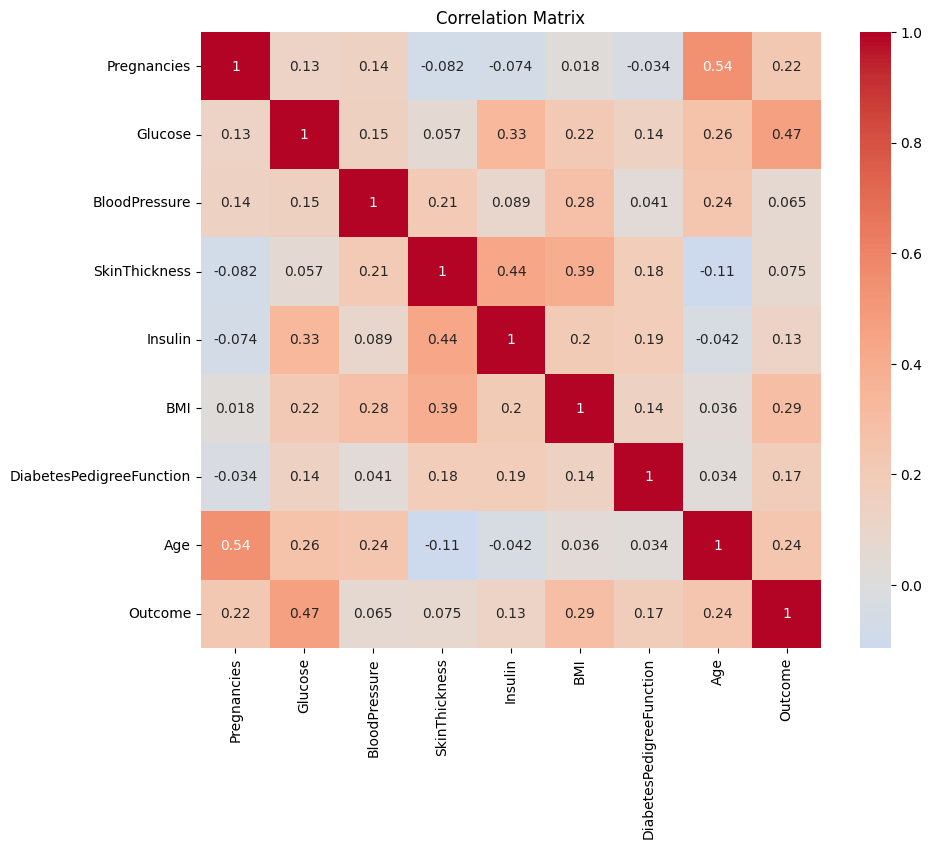

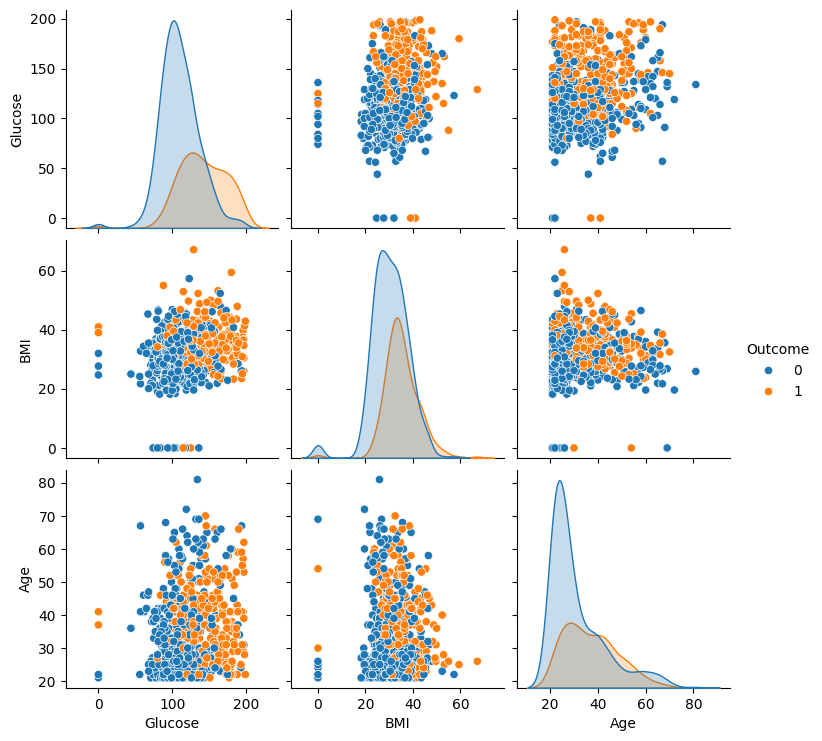

In [25]:
import matplotlib.pyplot as plt
import seaborn as sns

# Histograms of all features
df.hist(figsize=(12, 10))
plt.tight_layout()
plt.show()

# Correlation matrix heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm', center=0)
plt.title('Correlation Matrix')
plt.show()

# Pairplot of selected features
sns.pairplot(df[['Glucose', 'BMI', 'Age', 'Outcome']], hue='Outcome')
plt.show()

**Data preprocessing**

In [26]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import numpy as np

# Handle zero values in certain columns (which likely represent missing data)
# For Glucose, BloodPressure, SkinThickness, Insulin, BMI, we can't have zero values
zero_not_allowed = ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']

for column in zero_not_allowed:
    df[column] = df[column].replace(0, np.nan)
    mean = df[column].mean()
    df[column] = df[column].fillna(mean)

# Split data into features and target
X = df.drop('Outcome', axis=1)
y = df['Outcome']

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# **Model Training**

In [27]:
# Import additional required libraries
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score

# Initialize models with their best parameters (after tuning)
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000, C=0.1, penalty='l2', random_state=42),
    'Random Forest': RandomForestClassifier(n_estimators=100, max_depth=5, random_state=42),
    'Support Vector Machine': SVC(C=1.0, kernel='rbf', probability=True, random_state=42)
}

# Set up stratified 5-fold cross-validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Enhanced evaluation metrics collection
results = {}
for name, model in models.items():
    # Store all CV scores
    cv_acc = cross_val_score(model, X_train, y_train, cv=cv, scoring='accuracy')
    cv_prec = cross_val_score(model, X_train, y_train, cv=cv, scoring='precision')
    cv_rec = cross_val_score(model, X_train, y_train, cv=cv, scoring='recall')
    cv_f1 = cross_val_score(model, X_train, y_train, cv=cv, scoring='f1')
    cv_roc = cross_val_score(model, X_train, y_train, cv=cv, scoring='roc_auc')

    # Train model on full training set
    model.fit(X_train, y_train)

    # Test set predictions
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1] if hasattr(model, 'predict_proba') else None

    # Calculate metrics
    test_metrics = {
        'accuracy': accuracy_score(y_test, y_pred),
        'precision': precision_score(y_test, y_pred),
        'recall': recall_score(y_test, y_pred),
        'f1': f1_score(y_test, y_pred),
        'roc_auc': roc_auc_score(y_test, y_prob) if y_prob is not None else None,
        'confusion_matrix': confusion_matrix(y_test, y_pred),
        'classification_report': classification_report(y_test, y_pred, output_dict=True)
    }

    # Store all results
    results[name] = {
        'model': model,
        'cv_metrics': {
            'accuracy': {'mean': np.mean(cv_acc), 'std': np.std(cv_acc), 'all': cv_acc},
            'precision': {'mean': np.mean(cv_prec), 'std': np.std(cv_prec), 'all': cv_prec},
            'recall': {'mean': np.mean(cv_rec), 'std': np.std(cv_rec), 'all': cv_rec},
            'f1': {'mean': np.mean(cv_f1), 'std': np.std(cv_f1), 'all': cv_f1},
            'roc_auc': {'mean': np.mean(cv_roc), 'std': np.std(cv_roc), 'all': cv_roc}
        },
        'test_metrics': test_metrics
    }


# **Display results**

In [28]:
# Display results
for name, result in results.items():
    print(f"\n{'='*50}")
    print(f"{name} Performance")
    print(f"{'='*50}")

    print("\nCross-Validation Metrics:")
    cv_metrics = result['cv_metrics']
    for metric, values in cv_metrics.items():
        print(f"{metric.capitalize()}: {values['mean']:.4f} (±{values['std']:.4f})")
        print(f"All folds: {[f'{x:.4f}' for x in values['all']]}")

    print("\nTest Set Metrics:")
    test_metrics = result['test_metrics']
    for metric, value in test_metrics.items():
        if metric not in ['confusion_matrix', 'classification_report']:
            print(f"{metric.capitalize()}: {value:.4f}")

    print("\nClassification Report:")
    print(pd.DataFrame(test_metrics['classification_report']).transpose())

    print("\nConfusion Matrix:")
    print(test_metrics['confusion_matrix'])


Logistic Regression Performance

Cross-Validation Metrics:
Accuracy: 0.7557 (±0.0209)
All folds: ['0.7886', '0.7724', '0.7398', '0.7398', '0.7377']
Precision: 0.7001 (±0.0375)
All folds: ['0.7222', '0.6829', '0.7619', '0.6774', '0.6562']
Recall: 0.5261 (±0.1001)
All folds: ['0.6190', '0.6512', '0.3721', '0.4884', '0.5000']
F1: 0.5937 (±0.0645)
All folds: ['0.6667', '0.6667', '0.5000', '0.5676', '0.5676']
Roc_auc: 0.8380 (±0.0192)
All folds: ['0.8501', '0.8657', '0.8108', '0.8244', '0.8390']

Test Set Metrics:
Accuracy: 0.7662
Precision: 0.6939
Recall: 0.6182
F1: 0.6538
Roc_auc: 0.8228

Classification Report:
              precision    recall  f1-score     support
0              0.800000  0.848485  0.823529   99.000000
1              0.693878  0.618182  0.653846   55.000000
accuracy       0.766234  0.766234  0.766234    0.766234
macro avg      0.746939  0.733333  0.738688  154.000000
weighted avg   0.762099  0.766234  0.762928  154.000000

Confusion Matrix:
[[84 15]
 [21 34]]

Random F

# **Best Model Selection and Save the Model**

In [29]:
# Save the best model and scaler
import joblib

# Select the best model based on cross-validation ROC AUC
best_model_name = max(results, key=lambda x: results[x]['cv_metrics']['roc_auc']['mean'])
best_model = results[best_model_name]['model']
best_roc_auc = results[best_model_name]['cv_metrics']['roc_auc']['mean']

print(f"\n{'='*50}")
print(f"Best model: {best_model_name} with mean CV ROC AUC: {best_roc_auc:.4f}")
print(f"\nBest Model Accuracy: {results[best_model_name]['test_metrics']['accuracy']*100:.2f}%")
print(f"{'='*50}")

# Save the best model and scaler
joblib.dump(best_model, 'diabetes_model.pkl')
joblib.dump(scaler, 'scaler.pkl')


Best model: Support Vector Machine with mean CV ROC AUC: 0.8390

Best Model Accuracy: 75.32%


['scaler.pkl']